
# Оцінка та вдосконалення моделі


<h2>Мета</h2>

Ознайомитись з методами оцінки та вдосконалення регресійних моделей. Після завершення цієї лабораторної роботи ви зможете:

* Розділяти дані на навчальну та тестову вибірки
* Використовувати перехресну перевірку для оцінки якості моделі
* Обирати оптимальну складність моделі для уникнення перенавчання
* Вдосконалювати моделі прогнозування за допомогою підбору параметрів

Приблизний час виконання: **60** хвилин

# <h2>Зміст</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<h3>Завдання для тренування</h3>
<ul>
    <li><a href="#ref1">Оцінка моделі: навчання та тестування </a></li>
    <li><a href="#ref2">Overfitting, Underfitting та вибір моделі </a></li>
    <li><a href="#ref3">Гребенева регресія </a></li>
    <li><a href="#ref4">Підбір параметрів моделі (пошук по сітці)</a></li>
</ul>

</div>

<hr>

Імпорт бібліотек та даних:

In [1]:
#install specific version of libraries used in lab
#! mamba install pandas==1.3.3 -y
#! mamba install numpy=1.21.2 -y
#! mamba install sklearn=0.20.1 -y
#! mamba install ipywidgets=7.4.2 -y

# %pip install pandas
# %pip install numpy
# %pip install sklearn
# %pip install ipywidgets

import pandas as pd
import numpy as np


In [ ]:
# Якщо використовуєте Google Colaboratory

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/auto2.csv" # коренева папка вашого диску
path = "/content/drive/My Drive/data/auto2.csv" # не коренева папка вашого диску

In [37]:
# Якщо використовуєте Jupyter Notebook

# path = "automobileEDA.csv"

In [2]:
# Якщо забули зберегти дані, то скористайтесь цим файлом (This dataset was hosted on IBM Cloud object)

path='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/automobileEDA.csv'

In [3]:
df = pd.read_csv(path)

 Спочатку будемо використовувати тільки числові дані:


In [4]:
df=df._get_numeric_data()
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


<h3>Функції для побудови графіків</h3>


 Бібліотеки та функції для побудови графіків:


In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [6]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [7]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))


    #training data
    #testing data
    # lr:  linear regression object
    #poly_transform:  polynomial transformation object

    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

<a name="ref1"></a>
## <h2>Оцінка моделі: навчання та тестування</h2>

<p>Важливим кроком у тестуванні моделі є розділення даних на навчальні та тестові. Також розмістимо цільові дані (змінну-відгук) 'price' в окремому датафреймі <b>y_data</b>:</p>

In [8]:
y_data = df['price']

Видаляємо 'price' з датафрейму **x_data**:


In [9]:
x_data=df.drop('price',axis=1)

Тепер випадковим чином розділяємо наші дані на навчальні та тестові за допомогою функції <b>train_test_split</b>.

In [10]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 21
number of training samples: 180


Параметр <b>test_size</b> встановлює частку даних, які виділяються в тестовий набір. У наведеному вище коді набір для тестування становить 10% від загального набору даних.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #1:</h2>

<p>Використовуйте функцію "train_test_split", щоб розділити набір даних таким чином, щоб 40% використовувалося для тестування. Встановіть параметр "random_state" рівним нулю. Вихідні дані функції мають бути такими: "x_train1", "x_test1", "y_train1" і "y_test1".</p>
</div>


In [11]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.40, random_state=0)
print('number of test samples:', x_test1.shape[0])
print('number of training samples:', x_train1.shape[0])

number of test samples: 81
number of training samples: 120


<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])
```

</details>


Імпортуємо <b>LinearRegression</b> з модуля <b>linear_model</b>.


In [12]:
from sklearn.linear_model import LinearRegression

Створюємо об’єкт лінійної регресії:


In [13]:
lre=LinearRegression()

Підбираємо модель за ознакою 'horsepower':

In [14]:
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

Обчислимо R^2 на тестових даних:


In [15]:
lre.score(x_test[['horsepower']], y_test)

0.36358755750788274

Бачимо, що R^2 набагато менший, якщо обчислюємо його на тестових, а не навчальних даних.


In [16]:
lre.score(x_train[['horsepower']], y_train)

0.6619724197515104

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #2: </h2>
    
<p>Знайдіть R^2  на тестових даних, використовуючи 40% загального набору в якості тестових даних.
</p>
</div>


In [17]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
lre.fit(x_train1[['horsepower']], y_train1)
lre.score(x_test1[['horsepower']], y_test1)

0.7139364665406973

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
lre.fit(x_train1[['horsepower']],y_train1)
lre.score(x_test1[['horsepower']],y_test1)

```

</details>


Іноді у вас недостатньо даних тестування; тоді можна виконати перехресну перевірку. Розглянемо кілька методів, які можна використовувати для перехресної перевірки.

<h3>Перехресна перевірка (Cross-Validation Score)</h3>


Імпортуємо <b>model_selection</b> з модуля <b>cross_val_score</b>.


In [18]:
from sklearn.model_selection import cross_val_score

Вводимо об’єкт, ознаку ('horsepower') і цільові дані (y_data). Параметр "cv" визначає кількість фолдів, в нашому випадку їх 4 (при бажанні можна задавати іншу кількість, зазвичай в межах 4-10).

In [19]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

Оцінка за умовчанням R^2. Кожен елемент у масиві має середнє значення R^2 для фолду:

In [20]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

 Можемо обчислити середнє значення та стандартне відхилення нашої оцінки:


In [21]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5220099150421195 and the standard deviation is 0.2911839444756025


Можемо використовувати від’ємну квадратичну помилку як оцінку, встановивши для параметра "scoring" метрику "neg_mean_squared_error".

In [22]:
-1 * cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20254142.84026704, 43745493.26505169, 12539630.34014929,
       17561927.72247588])

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #3: </h2>
    
<p>Обчисліть середнє R^2, використовуючи два фолди, а потім знайдіть середнє R^2 для другого фолду, використовуючи ознаку 'horsepower':
</p>
</div>


In [23]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
Rcross2 = cross_val_score(lre, x_data[['horsepower']], y_data, cv=2)
Rcross2.mean()

np.float64(0.5166761697127429)

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
Rc=cross_val_score(lre,x_data[['horsepower']], y_data,cv=2)
Rc.mean()

```

</details>


Ви також можете використовувати функцію "cross_val_predict" для прогнозування результату. Функція розбиває дані на вказану кількість фолдів, причому один фолд для тестування, а інші фолди використовуються для навчання. Спочатку імпортуйте функцію:

In [24]:
from sklearn.model_selection import cross_val_predict

Вводимо об’єкт, ознаку 'horsepower' і цільові дані <b>y_data</b>. Параметр "cv" визначає кількість фолдів. У цьому випадку їх 4. Можемо отримати результат:

In [25]:
yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

<a name="ref2"></a>
## <h2>Overfitting, Underfitting та вибір моделі</h2>

<p>Виявилося, що тестові дані, які іноді називають "даними поза вибіркою", є набагато кращим показником ефективності вашої моделі в реальному світі. Однією з причин цього є перенавчання (overfitting).

Розглянемо кілька прикладів. Виявилося, що ці відмінності більш очевидні в множинній лінійній регресії та поліноміальній регресії, тому досліджуватимемо перенавчання на прикладі цих моделей.</p>

Давайте створимо кілька об’єктів лінійної регресії та навчимо моделі, використовуючи 'horsepower', 'curb-weight', 'engine-size' і 'highway-mpg' як ознаки-предиктори.

In [31]:
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression()

Прогнозування з використанням навчальних даних:


In [32]:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
       34500.19124244])

Прогнозування з використанням тестових даних:


In [33]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
       15565.79920282])

Виконаємо деяку оцінку моделі, використовуючи навчальні та тестові дані окремо. Спочатку імпортуємо бібліотеку seaborn і matplotlib для побудови діаграм.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Розглянемо розподіл прогнозованих значень для навчальних даних.

/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

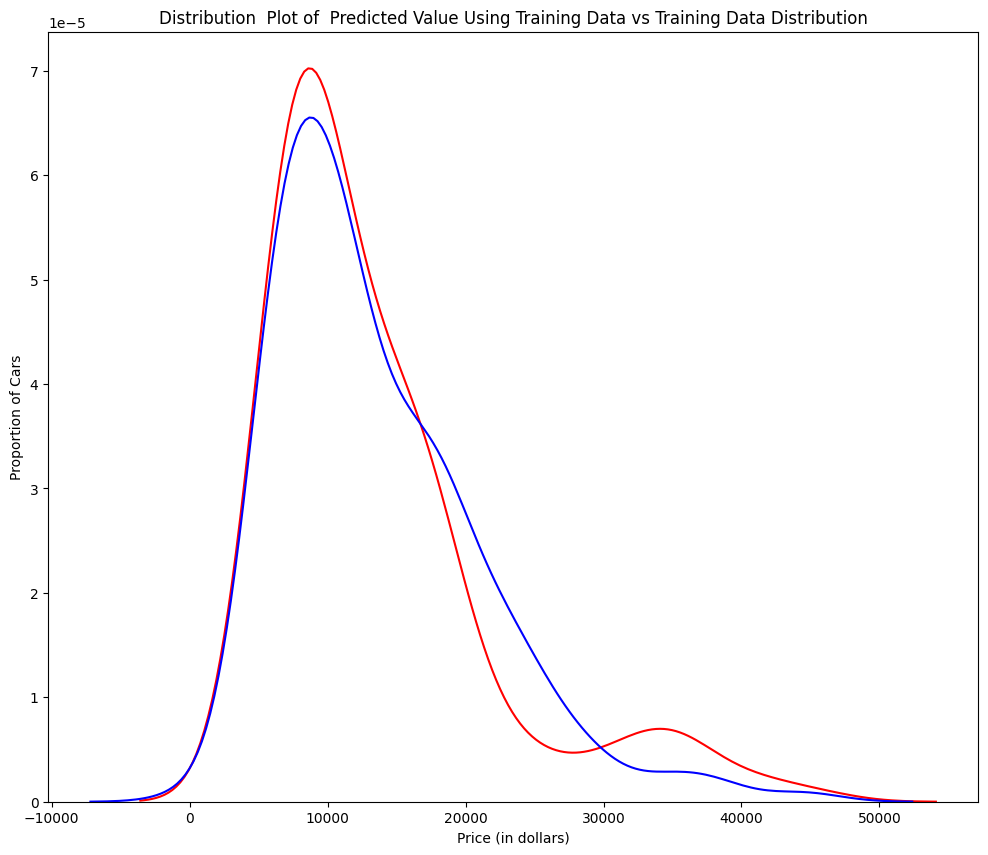

In [35]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Рисунок 1: Діаграма прогнозованих значень на основі навчальних даних порівняно з фактичними значеннями навчальних даних.


Поки що модель, здається, добре навчається з навчального набору даних. Але що відбувається, коли модель зустрічає нові дані з тестового набору даних? Коли модель генерує нові значення з тестових даних, бачимо, що розподіл прогнозованих значень сильно відрізняється від фактичних цільових значень.

/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

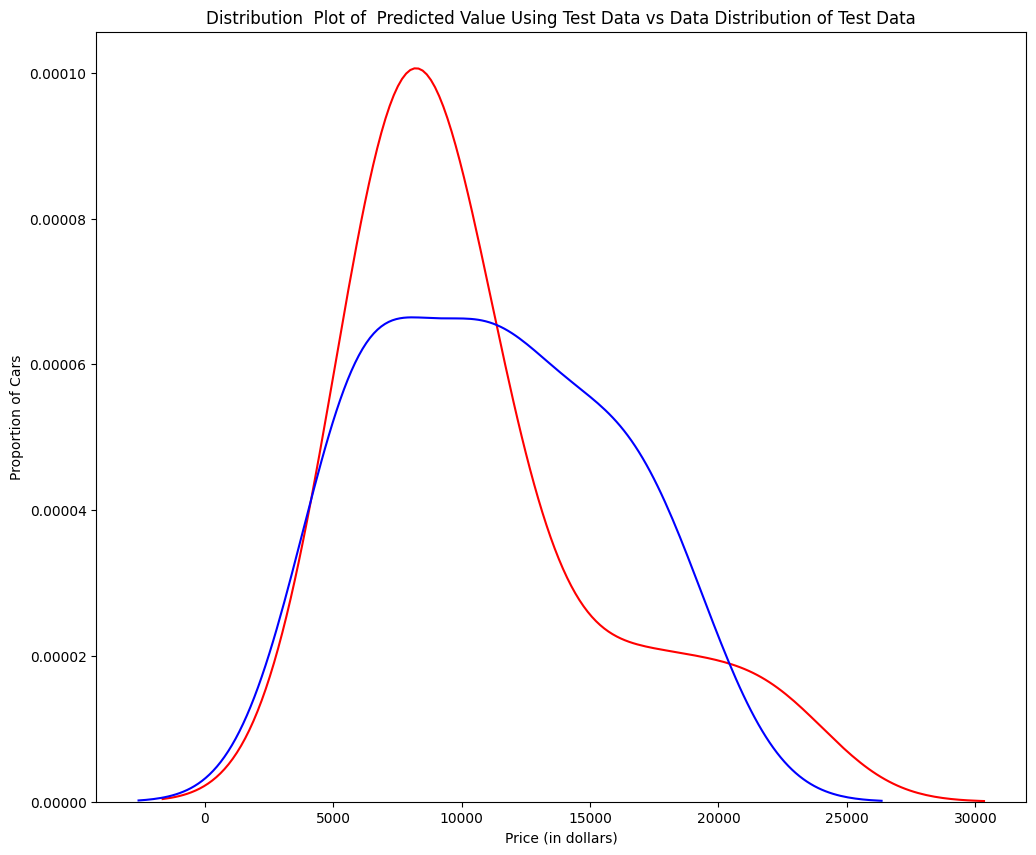

In [36]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Рисунок 2: Діаграма прогнозованих значень на основі тестових даних порівняно з фактичними значеннями тестових даних.

<p>При порівнянні рисунків стає очевидним, що розподіл тестових даних на рис.1 набагато краще відповідає даним. Ця різниця на рис.2 помітна в діапазоні від 5000 до 15 000. Тут форма розподілу надзвичайно відрізняється. </p>
<p>Давайте подивимося, чи поліноміальна регресія також демонструє падіння точності передбачення під час аналізу тестового набору даних.</p>

In [37]:
from sklearn.preprocessing import PolynomialFeatures

<h4>Overfitting</h4>
<p>Перенавчання відбувається, коли модель відповідає шуму, але не відповідає базовому процесу. Таким чином, під час тестування вашої моделі за допомогою тестового набору ваша модель не працює так добре, оскільки вона моделює шум, а не основний процес, який породив зв’язок. </p>

Створимо поліноміальну модель 5 ступеня. Використаємо 55 відсотків даних для навчання, а решту для тестування:


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

Виконаємо поліноміальне перетворення 5 ступеня для ознаки 'horsepower'.

In [39]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

Тепер створимо модель лінійної регресії "poly" і навчимо її.

In [40]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

Можемо побачити результати моделі за допомогою методу "predict". Присвоюємо значення "yhat".

In [41]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.75021272,  7308.07521482, 12213.82613379, 18893.10515877,
       19995.78509908])

Давайте візьмемо перші п’ять прогнозованих значень і порівняємо їх із фактичними.


In [42]:
print("Predicted values:", yhat[0:5])
print("True values:", y_test[0:5].values)

Predicted values: [ 6728.75021272  7308.07521482 12213.82613379 18893.10515877
 19995.78509908]
True values: [ 6295. 10698. 13860. 13499. 15750.]


Будемо використовувати функцію "PollyPlot", яку ми визначили на початку лабораторної роботи, щоб відобразити навчальні дані,  тестові дані та прогнозовану функцію.

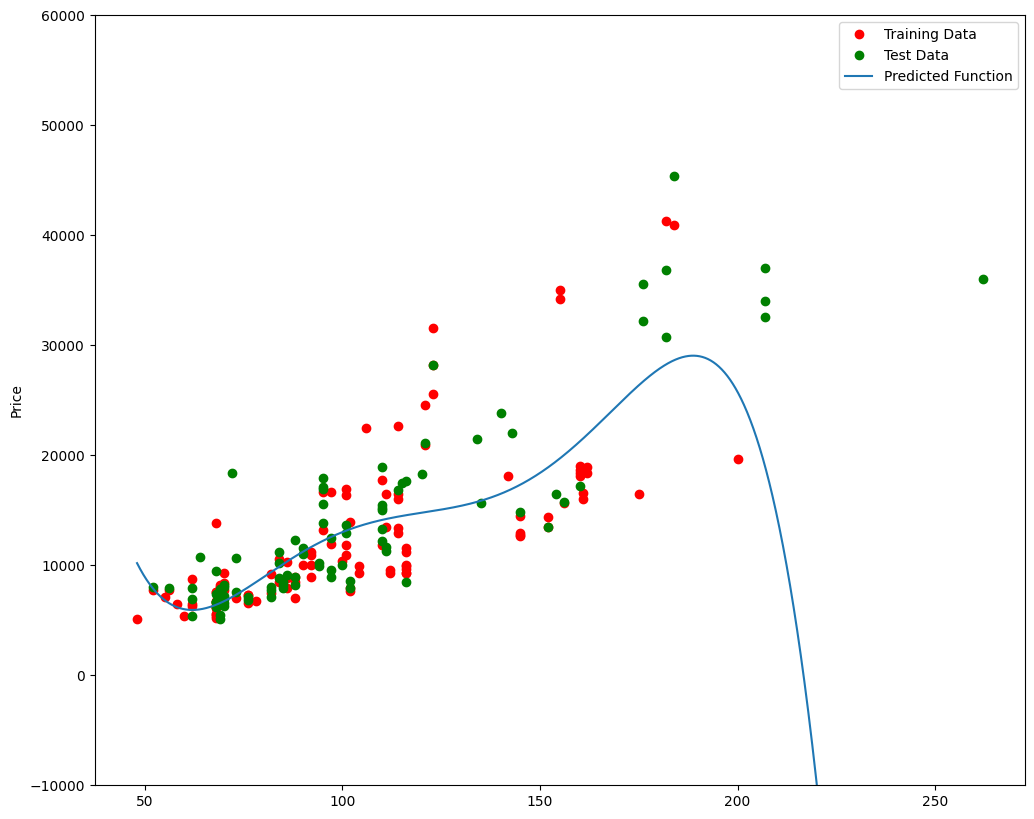

In [43]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

Рисунок 3: Модель поліноміальної регресії, де червоні крапки представляють навчальні дані, зелені крапки представляють тестові дані, а синя лінія - це прогноз моделі.

Бачимо, що оціночна функція, здається, відстежує дані, але приблизно на 200 кінських силах функція починає відхилятися від точок даних.

 R^2 на навчальних даних:


In [44]:
poly.score(x_train_pr, y_train)

0.5567716901486801

 R^2 на тестових даних:


In [45]:
poly.score(x_test_pr, y_test)

-29.871647964392377

Бачимо, що R^2 для навчальних даних становить 0.5567, тоді як R^2 для тестових даних становив -29.87. Чим менше R^2, тим гірша модель. Від’ємний R^2 є ознакою перенавчання.

Давайте подивимося, як змінюється R^2 на тестових даних для поліномів різних порядків, а потім побудуємо результати:


Text(3, 0.75, 'Maximum R^2 ')

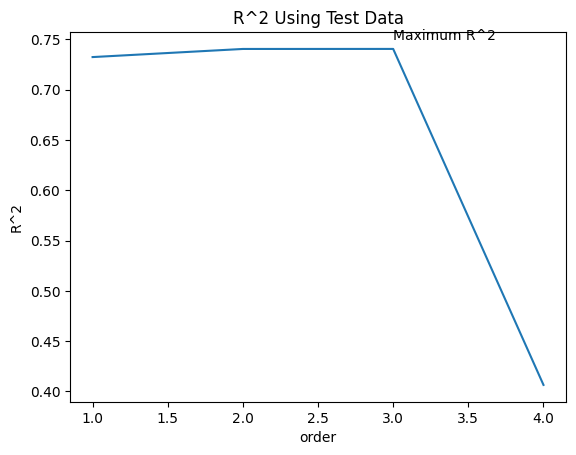

In [46]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)

    x_train_pr = pr.fit_transform(x_train[['horsepower']])

    x_test_pr = pr.fit_transform(x_test[['horsepower']])

    lr.fit(x_train_pr, y_train)

    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')

Бачимо, що R^2 поступово збільшується, поки не буде використано поліном третього порядку. Далі R^2 різко зменшується для полінома четвертого порядку.


Наступний інтерфейс дозволяє експериментувати з різними порядками поліномів і різними обсягами даних.


In [47]:
# Ця функція буде використана в наступному блоці. Будь ласка, запустіть на виконання
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

In [48]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f(order, test_data)>

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4a:</h2>

<p>Ми можемо виконувати поліноміальні перетворення з більш ніж однією ознакою. Створіть об'єкт "PolynomialFeatures" "pr1" другого ступеня.</p>
</div>


In [49]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
pr1=PolynomialFeatures(degree=2)

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
pr1=PolynomialFeatures(degree=2)

```

</details>


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4b: </h2>

<p>Перетворіть навчальну та тестову вибірки для ознак 'horsepower', 'curb-weight', 'engine-size' та 'highway-mpg'. </p><p>Підказка: використовуйте метод "fit_transform".</p>
</div>


In [50]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
x_train_pr1=pr1.fit_transform(x_train[['horsepower','curb-weight','engine-size','highway-mpg']])
x_test_pr1=pr1.fit_transform(x_test[['horsepower','curb-weight','engine-size','highway-mpg']])

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
```
</details>


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4c: </h2>
    
<p>Скільки вимірів має нова функція? </p><p>Підказка: використовуйте атрибут "shape".
</p>
</div>


In [53]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
x_train_pr1.shape

(110, 15)

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
x_train_pr1.shape #there are now 15 features
```

</details>


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4d: </h2>

<p>Створіть модель лінійної регресії "poly1". Навчіть об'єкт за допомогою методу "fit" використовуючи поліноміальні ознаки.</p></div>


In [54]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
poly1=LinearRegression()
poly1.fit(x_train_pr1, y_train)

LinearRegression()

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
poly1=LinearRegression().fit(x_train_pr1,y_train)
```

</details>


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4e: </h2>
    
<p>Використовуйте метод "predict", щоб спрогнозувати результати на поліноміальних ознаках, а потім скористайтеся функцією "DistributionPlot", щоб відобразити розподіл прогнозованих результатів для тестових даних порівняно з фактичними для тестових даних.</p>
</div>


/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
/var/folders/gj/d30kkjdn37n1x7z794t6qtm00000gn/T/ipykernel_1461/483544288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

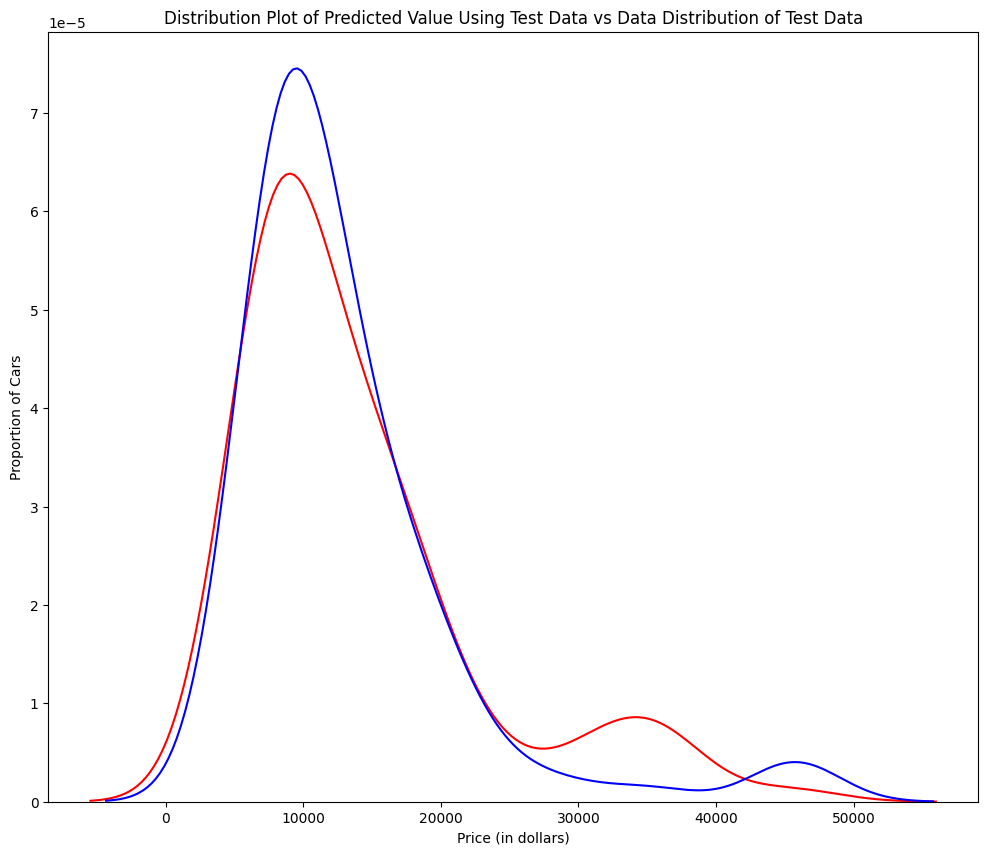

In [55]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
yhat_test1=poly1.predict(x_test_pr1)
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test, yhat_test1, 'Actual Values (Test)', 'Predicted Values (Test)', Title)

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
yhat_test1=poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)
```
</details>


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #4f: </h2>

<p>Використовуючи наведений вище графік розподілу, опишіть (словами) два регіони, де прогнозовані ціни менш точні, ніж фактичні ціни.</p>
</div>


In [ ]:
# Напишіть відповідь, виконувати не потрібно


<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
Прогнозована вартість вища за фактичну для автомобілів, ціна яких становить 10 000 доларів США,
навпаки, прогнозована ціна нижча за вартість у діапазоні від 30 000 до 40 000 доларів США.
Таким чином, модель не така точна в цих діапазонах.
```

</details>



<a name="ref3"></a>
## <h2>Гребенева регресія (Ridge Regression)</h2>


У цьому розділі розглянемо гребеневу регресію та побачимо, як параметр альфа змінює модель. Зверніть увагу: тут тестові дані використовуватимуться як дані для перевірки (validation data) правильності підбору параметра.

Виконаємо поліноміальне перетворення другого ступеня над нашими даними.


In [56]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

Імпортуємо <b>Ridge</b> з модуля <b>linear models</b>.

In [57]:
from sklearn.linear_model import Ridge

Створимо об’єкт гребеневої регресії, встановивши параметр регуляризації (alpha) на 0.1

In [58]:
RigeModel=Ridge(alpha=0.1)

Подібно до звичайної регресії будуємо модель за допомогою методу <b>fit</b>.


In [59]:
RigeModel.fit(x_train_pr, y_train)

/Users/saszco/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.02972e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.1)

Отримуємо прогноз:


In [60]:
yhat = RigeModel.predict(x_test_pr)

Порівняємо перші п’ять прогнозованих значень із нашим тестовим набором:


In [61]:
print('predicted:', yhat[0:5])
print('test set :', y_test[0:5].values)

predicted: [ 6567.83081933  9597.97151399 20836.22326843 19347.69543463
 21402.65500379]
test set : [ 6295. 10698. 13860. 13499. 15750.]


Далі вибираємо значення alpha, яке мінімізує помилку тесту. Для цього можемо використовувати цикл <code>for</code>. Ми також створили індикатор прогресу, щоб побачити, скільки ітерацій виконали на даний момент.

In [64]:
# %pip install tqdm
from tqdm import tqdm

Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha)
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)

    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

100%|██████████| 1000/1000 [00:02<00:00, 342.57it/s, Test Score=0.564, Train Score=0.859]


Можемо побудувати значення R^2 для різних alpha:

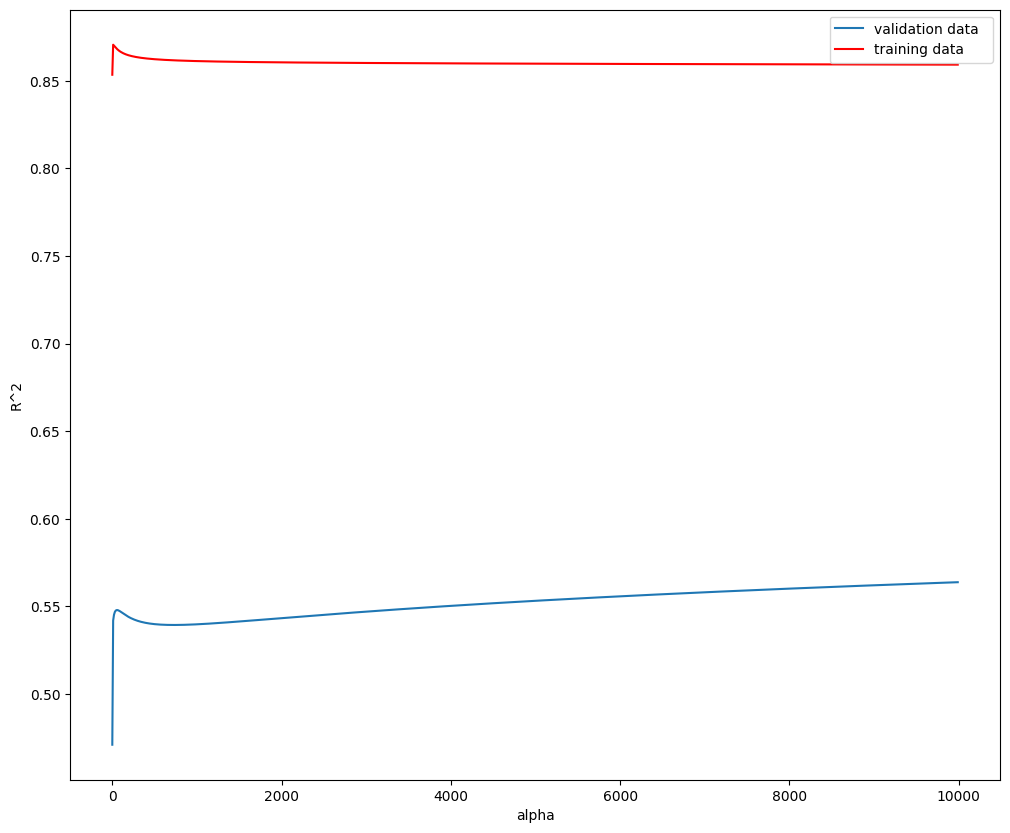

In [65]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

Рисунок 4. Синя лінія позначає R^2 для даних перевірки (validation data), а червона лінія позначає R^2 для навчальних даних. Вісь х представляє різні значення Alpha.

Тут модель побудована та протестована на тих самих даних, тому навчальні та тестові дані однакові.

Червона лінія на рис.4 представляє R^2 для навчальних даних. Зі збільшенням alpha R^2 зменшується. Тому зі збільшенням alpha модель гірше працює з навчальними даними.

Синя лінія позначає R^2 для даних перевірки. Коли значення alpha збільшується, R^2 збільшується і сходиться в точці.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #5: </h2>

Побудуйте модель гребеневої регресії. Обчисліть R^2 за допомогою поліноміальних ознак, використовуйте навчальні дані для навчання моделі та використайте тестові дані для перевірки моделі. Параметр alpha повинен бути встановлений на 10.
</div>


In [66]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
RigeModel=Ridge(alpha=10)
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)

0.5418576440206622

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
RigeModel = Ridge(alpha=10)
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)

```

</details>



<a name="ref4"></a>
## <h2>Підбір параметрів моделі - пошук по сітці (Grid Search)</h2>


Термін alpha є гіперпараметром. Sklearn має клас <b>GridSearchCV</b>, щоб спростити процес пошуку найкращого значення гіперпараметра.

Імпортуємо <b>GridSearchCV</b> з модуля <b>model_selection</b>.


In [67]:
from sklearn.model_selection import GridSearchCV

Створюємо словник значень параметрів:


In [68]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 1000000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}]

Створюємо об’єкт гребеневої регресії:


In [69]:
RR=Ridge()
RR

Ridge()

Створюємо об’єкт сітки пошуку параметра гребеневої регресії:

In [70]:
Grid1 = GridSearchCV(RR, parameters1, cv=4)

Підбираємо модель:

In [71]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    1000000]}])

Об’єкт знаходить найкращі значення параметрів для даних перевірки. Можемо отримати модель з найкращими параметрами та призначити її змінній BestRR наступним чином:

In [72]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

Тепер протестуємо нашу модель на тестових даних:


In [73]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.841164983103615

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<h2> Завдання  #6: </h2>

Виконайте пошук по сітці для параметра alpha та параметра нормалізації, а потім побудуйте модель, використавши найкращі значення параметрів:
</div>


In [77]:
# Напишіть ваш код нижче та натисніть Shift+Enter для виконання
parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
Grid2 = GridSearchCV(Ridge(), parameters2,cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
Grid2.best_estimator_

ValueError: Invalid parameter 'normalize' for estimator Ridge(alpha=0.001). Valid parameters are: ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol'].

<details><summary>Натисніть тут, щоб побачити підказку</summary>

```python
parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
Grid2 = GridSearchCV(Ridge(), parameters2,cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
Grid2.best_estimator_


```

</details>



*В теоретичній частині роботи використано елементи курсу "Data Analysis with Python" від IBM Corporation, автор
<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork971-2022-01-01" target="_blank">Joseph Santarcangelo</a>*